In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import statsmodels.api as sm

import keras
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

Using TensorFlow backend.


# Importieren und Manipulieren der Daten

In [2]:
SI = pd.read_csv("Data/seaice.csv")
GT = pd.read_csv("Global Temperature/GlobalTemperatures.csv")

In [3]:
SI = SI.drop([' Source Data', "    Missing"], axis=1)

In [4]:
SI = SI.rename(columns={"     Extent": "Extent", " Day": "Day", " Month": "Month"})

In [5]:
SI['Date'] = pd.to_datetime(SI[['Year','Month','Day']])
GT['dt'] = GT['dt'].astype('datetime64[ns]')

In [6]:
SI.head()

,Year,Month,Day,Extent,hemisphere,Date
0,1978,10,26,10.231,north,1978-10-26
1,1978,10,28,10.420,north,1978-10-28
2,1978,10,30,10.557,north,1978-10-30
3,1978,11,1,10.670,north,1978-11-01
4,1978,11,3,10.777,north,1978-11-03


In [7]:
GT.head()

,dt,LandAverageTemperature,LandAverageTemperatureUncertainty,LandMaxTemperature,LandMaxTemperatureUncertainty,LandMinTemperature,LandMinTemperatureUncertainty,LandAndOceanAverageTemperature,LandAndOceanAverageTemperatureUncertainty
0,1750-01-01,3.034,3.574,NaN,NaN,NaN,NaN,NaN,NaN
1,1750-02-01,3.083,3.702,NaN,NaN,NaN,NaN,NaN,NaN
2,1750-03-01,5.626,3.076,NaN,NaN,NaN,NaN,NaN,NaN
3,1750-04-01,8.490,2.451,NaN,NaN,NaN,NaN,NaN,NaN
4,1750-05-01,11.573,2.072,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
SI.index = SI['Date'].values
GT.index = GT['dt'].values

In [9]:
SIN = SI[SI['hemisphere'] == 'north']
SIS = SI[SI['hemisphere'] == 'south']

# Plot Northern and Southern Hemisphere

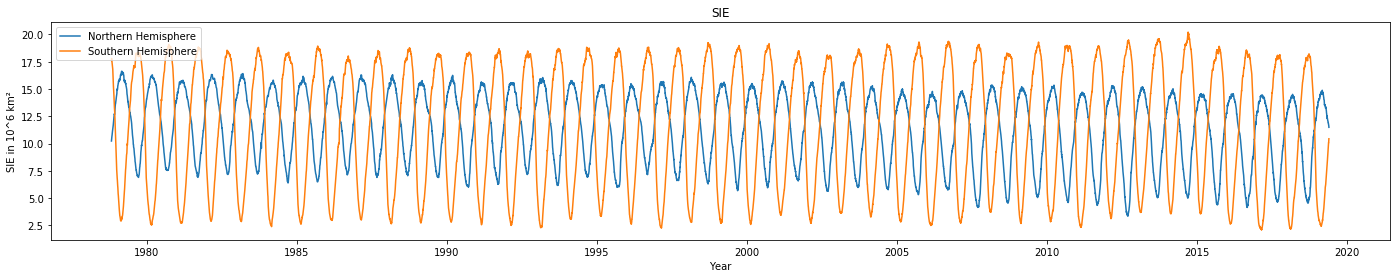

In [10]:
plt.figure(figsize=(24,4))

plt.plot(SIN['Date'], SIN['Extent'], label = 'Northern Hemisphere')
plt.plot(SIS['Date'], SIS['Extent'], label = 'Southern Hemisphere')
plt.xlabel('Year')
plt.ylabel('SIE in 10^6 km²')
plt.title('SIE')
plt.legend();

In [11]:
SINYAVG = SIN['01-01-1979':'31-12-2018'].resample('12M').mean()
SISYVG = SIS['01-01-1979':'31-12-2018'].resample('12M').mean()

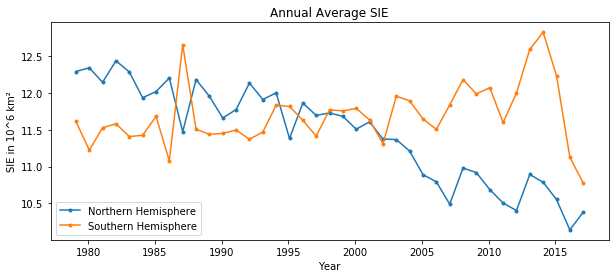

In [12]:
plt.figure(figsize=(10,4))

plt.plot(SINYAVG.Year[1:-1],SINYAVG['Extent'][1:-1], marker = '.', label='Northern Hemisphere')
plt.plot(SISYVG.Year[1:-1],SISYVG['Extent'][1:-1], marker = '.', label='Southern Hemisphere')
plt.xlabel('Year')
plt.ylabel('SIE in 10^6 km²')
plt.title('Annual Average SIE')
plt.legend();

# Splitting in Train and Test Data

In [13]:
SIN = SIN.drop(["hemisphere"], axis=1)
SIS = SIS.drop(["hemisphere"], axis=1)
# Start tägliche Messung: 1987-08-20
# Letzte Messung: 2019-05-31

## Nur die Daten nehmen an denen eine tägliche Messung stattgefunden hat

In [14]:
SIN = SIN["1987-08-20":"2019-05-31"]
SIS = SIS["1987-08-20":"2019-05-31"]

In [15]:
XN = np.arange(1, 11568, 1).reshape(-1, 1)
XS = np.arange(1, 11568, 1).reshape(-1, 1)

In [16]:
yn = SIN[['Extent']].values
ys = SIS[['Extent']].values

In [17]:
XN_train, XN_test, yn_train, yn_test = train_test_split(XN,yn, test_size = 0.25, shuffle = False)
XS_train, XS_test, ys_train, ys_test = train_test_split(XS,ys, test_size = 0.25, shuffle = False)

# Lineare Regression


In [18]:
NLmodel = LinearRegression()
NLmodel.fit(XN_train, yn_train);

SLmodel = LinearRegression()
SLmodel.fit(XS_train, ys_train);

print(NLmodel.score(XN_test, yn_test))

-0.0075392048985623026


Steigung der Geraden (Nmodel): [[-0.00014192]]
Steigung der Geraden (Smodel): [[7.78345689e-06]]


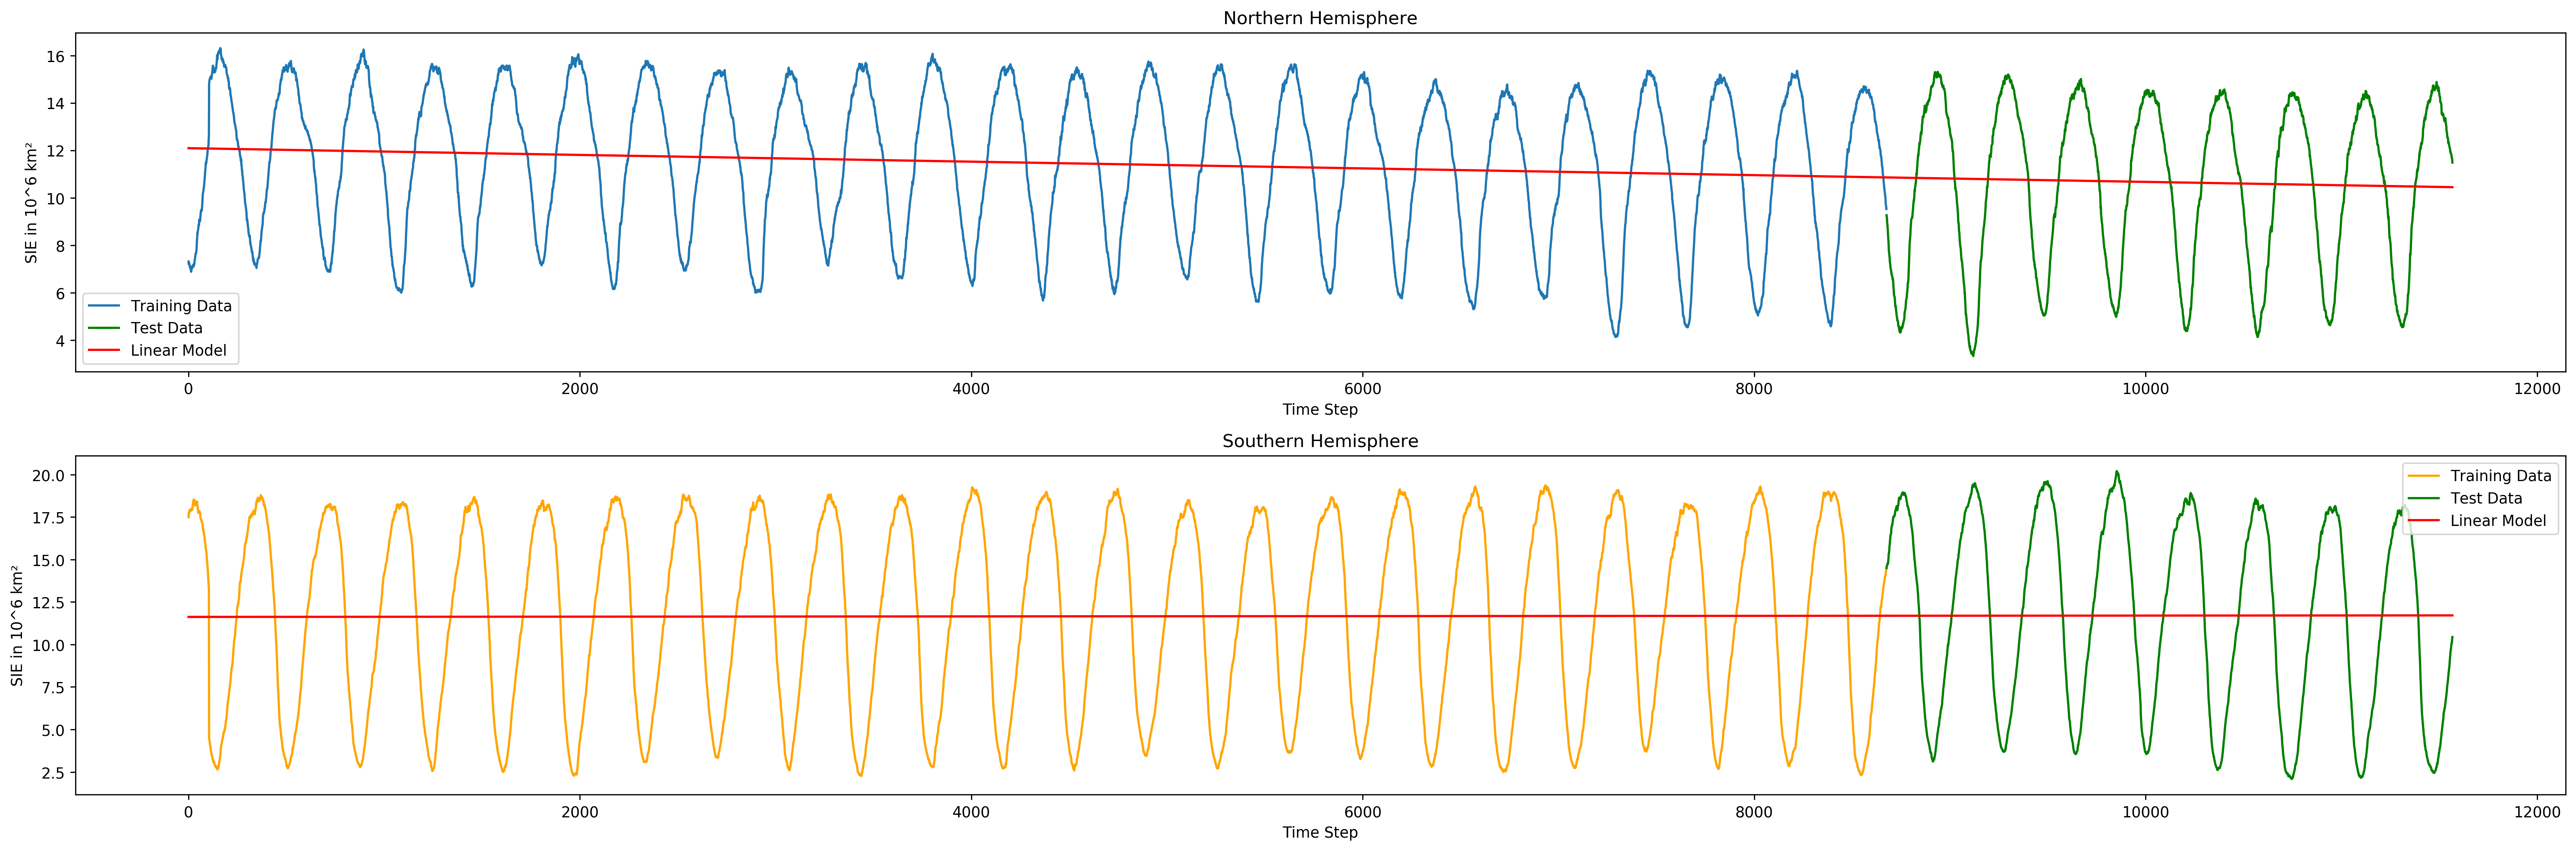

In [19]:
plt.figure(figsize=(24, 8), dpi= 250)

plt.subplot(211)
plt.title('Northern Hemisphere')
plt.plot(XN_train, yn_train, label = "Training Data")
plt.plot(XN_test, yn_test, 'g', label = "Test Data")
plt.plot(XN_train, NLmodel.predict(XN_train),'r', label = 'Linear Model')
plt.plot(XN_test, NLmodel.predict(XN_test),'r')
plt.xlabel('Time Step')
plt.ylabel('SIE in 10^6 km²')
plt.legend()
print("Steigung der Geraden (Nmodel): " + str(NLmodel.coef_))

plt.subplot(212)
plt.title('Southern Hemisphere')
plt.plot(XS_train, ys_train, 'orange',label = "Training Data")
plt.plot(XS_test, ys_test, 'g', label = "Test Data")
plt.plot(XS_train, SLmodel.predict(XS_train), 'r', label = 'Linear Model')
plt.plot(XS_test, SLmodel.predict(XS_test), 'r')
plt.xlabel('Time Step')
plt.ylabel('SIE in 10^6 km²')
plt.legend()
print("Steigung der Geraden (Smodel): " + str(SLmodel.coef_))
plt.tight_layout();

# Benchmark Model

In [20]:
NResLinTrain = yn_train - NLmodel.predict(XN_train)
SResLinTrain = ys_train - SLmodel.predict(XS_train)

NResLinTest = yn_test - NLmodel.predict(XN_test)
SResLinTest = ys_test - SLmodel.predict(XS_test)

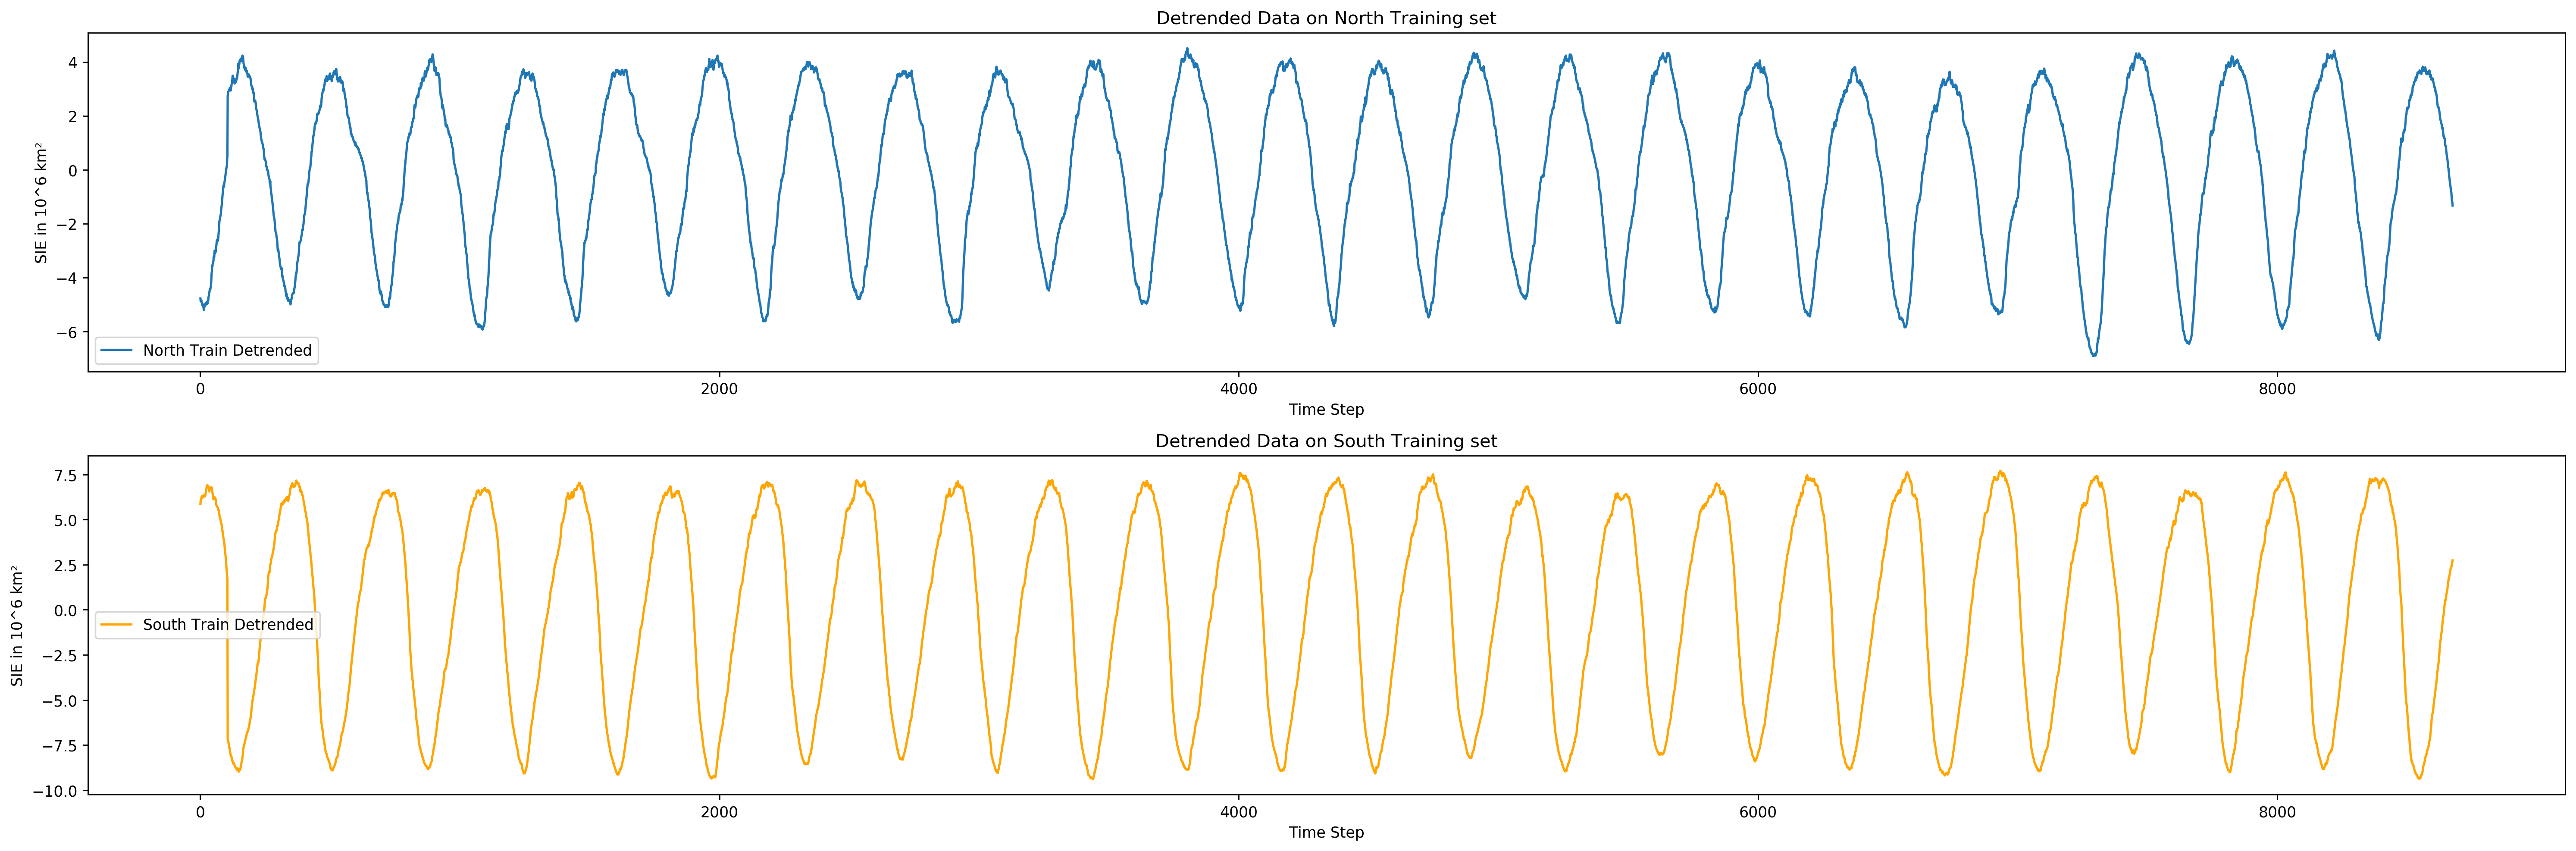

In [21]:
plt.figure(figsize=(24, 8), dpi= 250)

plt.subplot(211)
plt.plot(XN_train, NResLinTrain, label = 'North Train Detrended')
plt.ylabel('SIE in 10^6 km²') 
plt.xlabel('Time Step')
plt.legend()
plt.title('Detrended Data on North Training set')

plt.subplot(212)
plt.plot(XS_train, SResLinTrain, 'orange', label = 'South Train Detrended')
plt.ylabel('SIE in 10^6 km²')
plt.xlabel('Time Step')
plt.legend();
plt.title('Detrended Data on South Training set')

plt.tight_layout();

# ACF and PACF 
## nördliche Hemisphäre

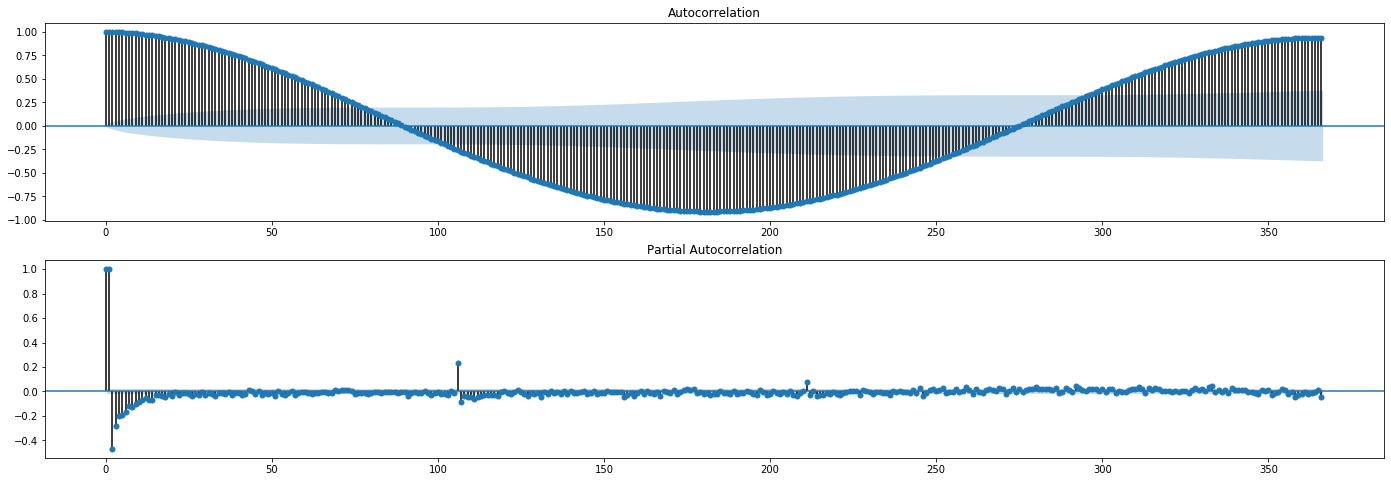

In [22]:
fig = plt.figure(figsize=(24,8)) 
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(NResLinTrain, lags=366, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(NResLinTrain, lags=366, ax=ax2)

## südliche Hemisphäre

C:\Users\pafal\Anaconda3\envs\python3.6\lib\site-packages\statsmodels\regression\linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


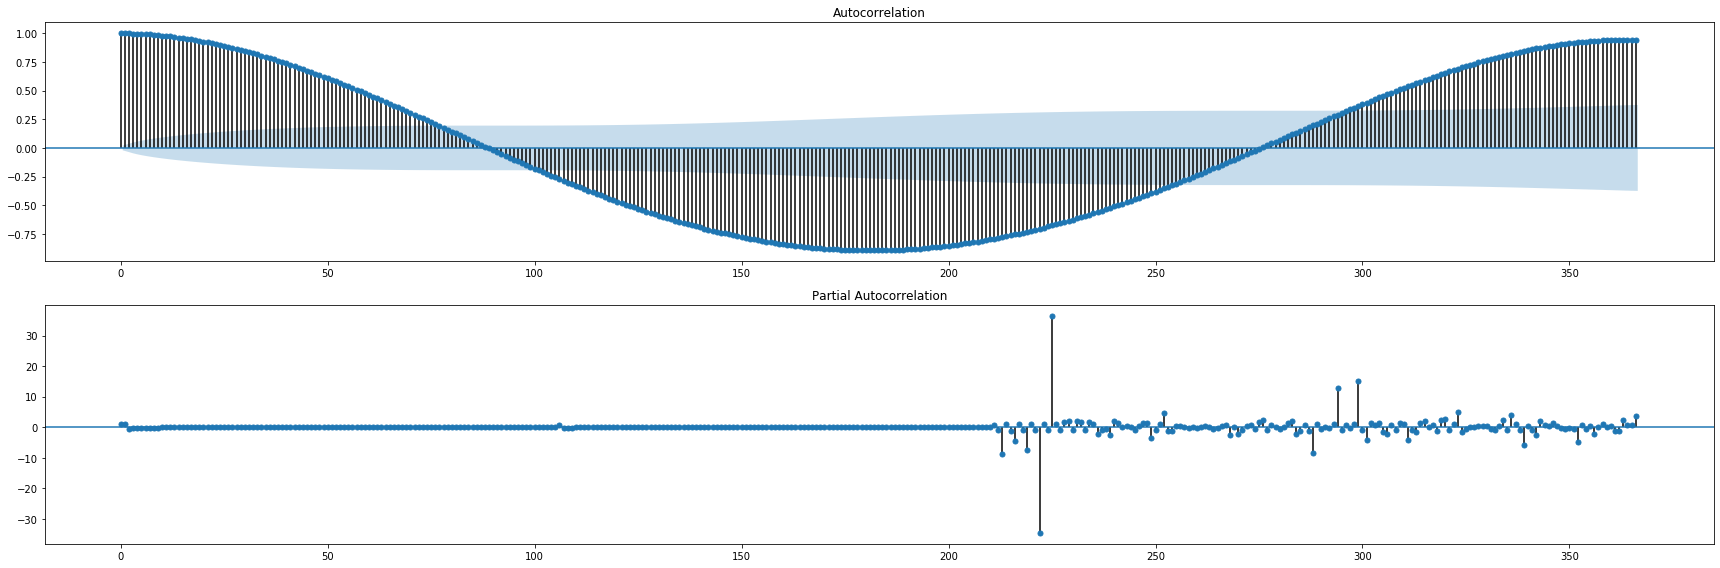

In [23]:
fig = plt.figure(figsize=(24,8)) 
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(SResLinTrain, lags=366, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(SResLinTrain, lags=366, ax=ax2)
plt.tight_layout(); 

Sowohl bei nördlichen als auch bei der südlichen Hemisphäre:

PACF ist endlich und verschwindet nach P Schritten.

ACF aber weder gedämpft fallend noch gedämpfte Schwingung.

ACF wiederholt sich nach ca. 360 lags.

In [24]:
NResLinTrain = np.array(NResLinTrain)
NResLinTest = np.array(NResLinTest)

SResLinTrain = np.array(SResLinTrain)
SResLinTest = np.array(SResLinTest)

# ARMA

In [25]:
Narma_mod20 = sm.tsa.ARMA(NResLinTrain, (2,0)).fit()
Sarma_mod20 = sm.tsa.ARMA(SResLinTrain, (2,0)).fit()

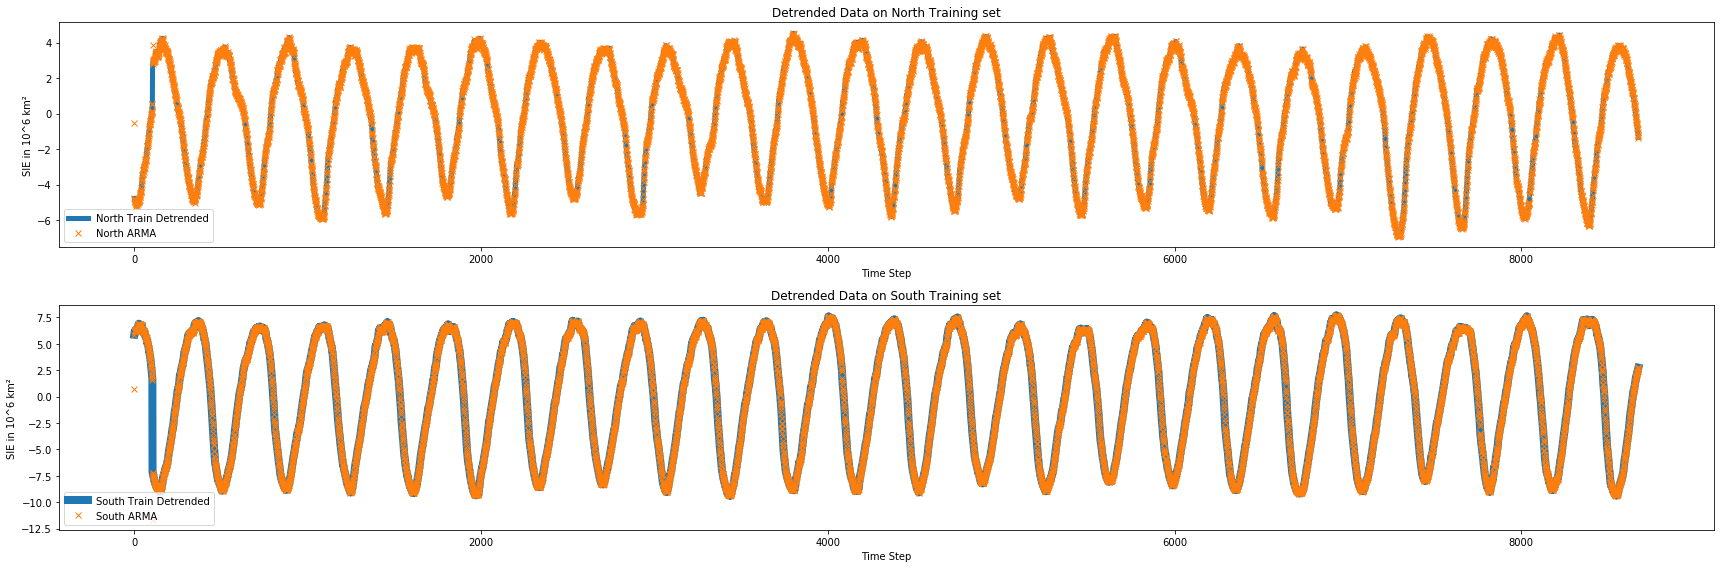

In [26]:
fig = plt.figure(figsize=(24,8))

plt.subplot(211)
plt.plot(XN_train, NResLinTrain, label = 'North Train Detrended', lw = 5)
plt.plot(Narma_mod20.predict(start=0, end=8675), 'x', label='North ARMA')
plt.ylabel('SIE in 10^6 km²'); 
plt.xlabel('Time Step');
plt.legend();
plt.title('Detrended Data on North Training set');

plt.subplot(212)
plt.plot(XS_train, SResLinTrain, label = 'South Train Detrended', lw = 8)
plt.plot(Sarma_mod20.predict(start=0, end=8675), 'x', label='South ARMA')
plt.ylabel('SIE in 10^6 km²'); 
plt.xlabel('Time Step');
plt.legend();
plt.title('Detrended Data on South Training set')
plt.tight_layout();

# MLP Network

In [27]:
XN_train, XN_test = SIN[:-2892], SIN[-2892:]
XS_train, XS_test = SIS[:-2892], SIS[-2892:]

## Y-Werte = Extent

In [28]:
yn_train = XN_train.drop(["Year", "Date", "Day", "Month", "Year"], axis = 1)
yn_test = XN_test.drop(["Year", "Date", "Day", "Month", "Year"], axis = 1)

ys_train = XS_train.drop(["Year", "Date", "Day", "Month", "Year"], axis = 1)
ys_test = XS_test.drop(["Year", "Date", "Day", "Month", "Year"], axis = 1)

## X-Werte = Kalenderinfo

In [29]:
XN_train = XN_train.drop(['Extent','Date'], axis = 1)
XN_test = XN_test.drop(['Extent','Date'], axis = 1)

XS_train = XS_train.drop(['Extent','Date'], axis = 1)
XS_test = XS_test.drop(['Extent','Date'], axis = 1)

## Um die Fehlerfunktion zu visualisieren

In [30]:
from IPython.display import clear_output

class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []
        
    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait = True)
        plt.plot(self.x, self.losses, label = "loss", color = 'r')
        plt.plot(self.x, self.val_losses, label = "val_loss", color = 'blue')
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()

## Skalieren der Eingabedaten

In [31]:
from sklearn import preprocessing

# NORTH

scalerXN = preprocessing.StandardScaler().fit(XN_train)
XN_train_transformed = scalerXN.transform(XN_train)

scalerXNtest = preprocessing.StandardScaler().fit(XN_test)
XN_test_transformed = scalerXNtest.transform(XN_test)

scaleryn = preprocessing.StandardScaler().fit(yn_train)
yn_train_transformed = scaleryn.transform(yn_train)

scaleryntest = preprocessing.StandardScaler().fit(yn_test)
yn_test_transformed = scaleryntest.transform(yn_test)

# SOUTH

scalerXS = preprocessing.StandardScaler().fit(XS_train)
XS_train_transformed = scalerXS.transform(XS_train)

scalerXStest = preprocessing.StandardScaler().fit(XS_train)
XS_test_transformed = scalerXStest.transform(XS_test)

scalerys = preprocessing.StandardScaler().fit(ys_train)
ys_train_transformed = scalerys.transform(ys_train)

scalerystest = preprocessing.StandardScaler().fit(ys_test)
ys_test_transformed = scalerystest.transform(ys_test)

## North Neural Network

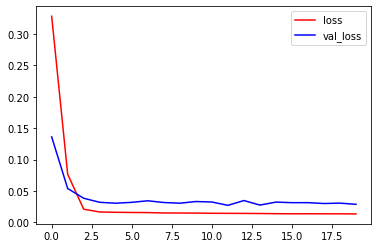

In [32]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD

modelNorth = Sequential()
modelNorth.add(Dense(100, input_dim=3, kernel_initializer='normal', activation ='tanh'))
modelNorth.add(Dense(250, activation = 'tanh'))
modelNorth.add(Dense(500, activation = 'tanh'))
modelNorth.add(Dense(250, activation = 'tanh'))
modelNorth.add(Dense(100, activation = 'tanh'))
modelNorth.add(Dense(1, kernel_initializer='normal', activation = 'linear'))

sgd = SGD(lr=0.2, momentum = 0.9, nesterov=True)

modelNorth.compile(loss='mean_squared_error', optimizer='sgd')

historyNorth = modelNorth.fit(XN_train_transformed, yn_train_transformed,
                             shuffle = True,
                             epochs = 20,
                             batch_size = 10,
                             verbose = 1,
                             validation_data = (XN_test_transformed, yn_test_transformed),
                             callbacks = [plot_losses])

## South Neural Network

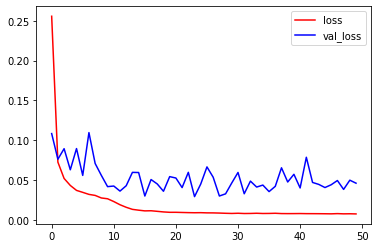

In [35]:
modelSouth = Sequential()
modelSouth.add(Dense(100, input_dim=3, kernel_initializer='normal', activation ='tanh'))
modelSouth.add(Dense(250, activation = 'tanh'))
modelSouth.add(Dense(500, activation = 'tanh'))
modelSouth.add(Dense(250, activation = 'tanh'))
modelSouth.add(Dense(100, activation = 'tanh'))
modelSouth.add(Dense(1, kernel_initializer='normal', activation = 'linear'))

sgd = SGD(lr=0.1, momentum = 0.7, nesterov=True)

modelSouth.compile(loss='mean_squared_error', optimizer='sgd')

historySouth = modelSouth.fit(XS_train_transformed, ys_train_transformed,
                             shuffle = True,
                             epochs = 50,
                             batch_size = 10,
                             verbose = 1,
                             validation_data = (XS_test_transformed, ys_test_transformed),
                             callbacks = [plot_losses])

In der südlichen Hemisphäre tut sich das Neuronale Netz schwerer im Lernprozess. Wie man an der Grafik oben sehen kann.

In [37]:
yn_predicted = modelNorth.predict(XN_test_transformed)
ys_predicted = modelSouth.predict(XS_test_transformed)

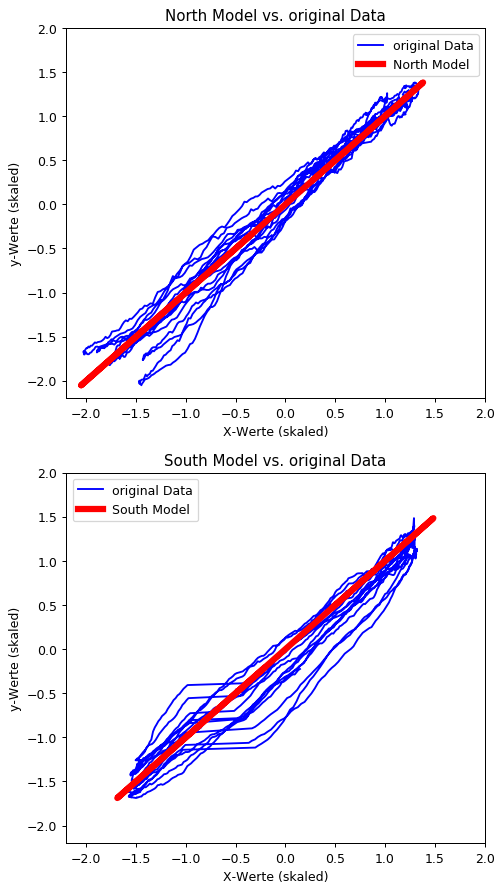

In [38]:
plt.figure(figsize = (6,12), dpi = 90)

plt.subplot(211)
plt.plot(yn_predicted, yn_test_transformed, color = 'blue', label = 'original Data')
plt.plot(yn_test_transformed, yn_test_transformed, lw = 5, color = 'r', label = 'North Model')
plt.axis([-2.2,2,-2.2,2]);
plt.xlabel('X-Werte (skaled)')
plt.ylabel('y-Werte (skaled)')
plt.legend()
plt.title('North Model vs. original Data');


plt.subplot(212)
plt.plot(ys_predicted, ys_test_transformed, color = 'blue', label = 'original Data')
plt.plot(ys_test_transformed, ys_test_transformed, lw = 5, color = 'r', label = 'South Model')
plt.axis([-2.2,2,-2.2,2]);
plt.xlabel('X-Werte (skaled)')
plt.ylabel('y-Werte (skaled)')
plt.legend()
plt.title('South Model vs. original Data');


## Modelle auf Testdaten anwenden

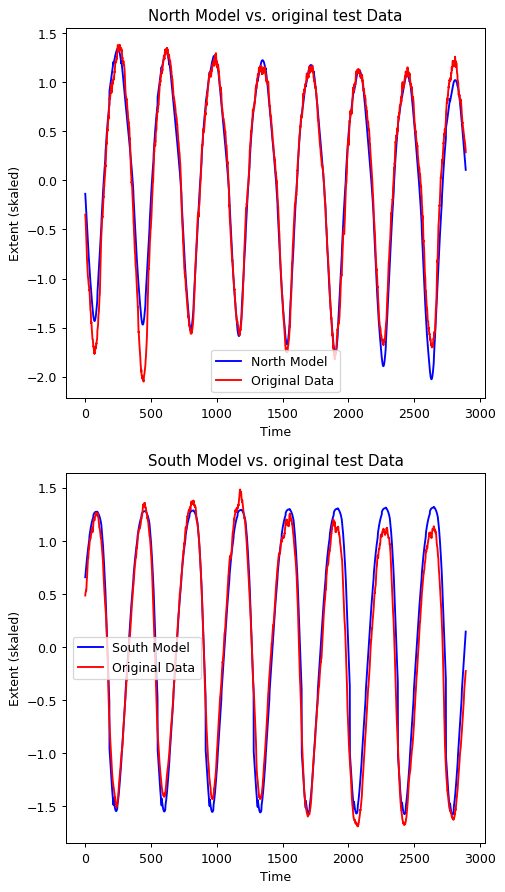

In [39]:
plt.figure(figsize=(6, 12), dpi = 90)

plt.subplot(211)
plt.plot(yn_predicted, color = 'blue', label = 'North Model')
plt.plot(yn_test_transformed, color = 'r', label='Original Data')
plt.xlabel('Time')
plt.ylabel('Extent (skaled)')
plt.legend()
plt.title('North Model vs. original test Data');


plt.subplot(212)
plt.plot(ys_predicted, color = 'blue', label = 'South Model')
plt.plot(ys_test_transformed, color = 'r', label='Original Data')
plt.xlabel('Time')
plt.ylabel('Extent (skaled)')
plt.legend()
plt.title('South Model vs. original test Data');

## Dataframe für Prognosezeitraum erstellen

In [40]:
prognosejahre = 1
# MAX 243

prognosetage = 365 * prognosejahre

rng = pd.date_range('2019-06-01', periods=prognosetage, freq="D")
dfprognose = pd.DataFrame({'Date': rng})

In [41]:
datetimes = pd.to_datetime(dfprognose["Date"])

dfprognose['Year'] = datetimes.dt.year
dfprognose['Month'] = datetimes.dt.month
dfprognose['Day'] = datetimes.dt.day

In [42]:
dfprog = dfprognose.drop(['Date'], axis=1)

In [43]:
scalerPROG = preprocessing.StandardScaler().fit(dfprog)
Prog_transformed = scalerPROG.transform(dfprog)

In [44]:
NPROG = modelNorth.predict(Prog_transformed)
SPROG = modelSouth.predict(Prog_transformed)

## Prognose für einen bestimmten Prognosezeitraum

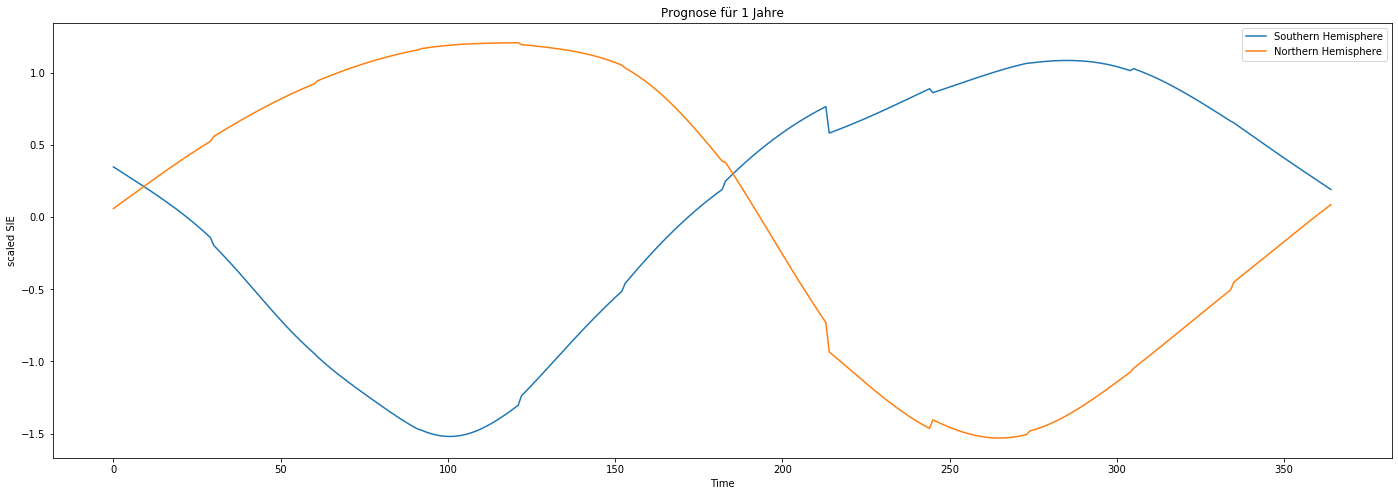

In [45]:
fig = plt.figure(figsize=(24,8))
plt.plot(NPROG, label='Southern Hemisphere')
plt.plot(SPROG, label='Northern Hemisphere')
plt.title('Prognose für '+ str(prognosejahre) + ' Jahre')
plt.xlabel('Time')
plt.legend()
plt.ylabel('scaled SIE');

# Globalen Temperaturen als Input

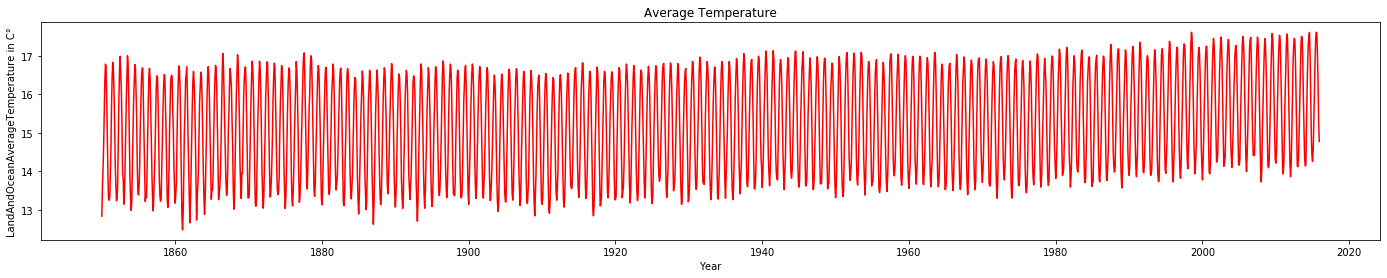

In [46]:
plt.figure(figsize=(24,4));
plt.plot(GT['dt'], GT['LandAndOceanAverageTemperature'], color='red')
# plt.plot(GT['dt'], GT['LandAverageTemperature'])
plt.title("Average Temperature")
plt.ylabel('LandAndOceanAverageTemperature in C°')
plt.xlabel('Year');

In [47]:
GT = GT[["dt", "LandAverageTemperature", "LandAndOceanAverageTemperature"]]

In [48]:
GT = GT.drop(['LandAverageTemperature'], axis=1)

In [49]:
GT = GT[1200::]
# Null Werte entfernen

# Neural Network with Global Temperature Input

In [50]:
XT = GT[['dt']]
yt = GT[['LandAndOceanAverageTemperature']]

In [51]:
XT["day"] = XT['dt'].map(lambda x: x.day)
XT["month"] = XT['dt'].map(lambda x: x.month)
XT["year"] = XT['dt'].map(lambda x: x.year)

In [52]:
XT = XT.drop(['dt'], axis=1)

In [53]:
scalerXT = preprocessing.StandardScaler().fit(XT)
XT_transformed = scalerXT.transform(XT)

scaleryt = preprocessing.StandardScaler().fit(yt)
yt_transformed = scaleryt.transform(yt)

XT_train, XT_test, yt_train, yt_test = train_test_split(XT_transformed,yt_transformed, test_size = 0.25, shuffle = False)

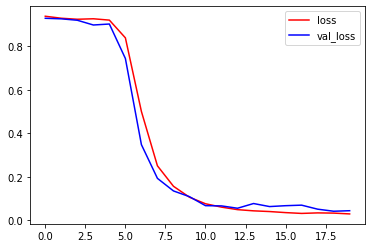

In [54]:
modelTemp = Sequential()
modelTemp.add(Dense(100, input_dim=3, kernel_initializer='normal', activation ='tanh'))
modelTemp.add(Dense(250, activation = 'tanh'))
modelTemp.add(Dense(500, activation = 'tanh'))
modelTemp.add(Dense(250, activation = 'tanh'))
modelTemp.add(Dense(100, activation = 'tanh'))

modelTemp.add(Dense(1, kernel_initializer='normal', activation = 'linear'))

sgd = SGD(lr=0.2, momentum = 0.9, nesterov=True)

modelTemp.compile(loss='mean_squared_error', optimizer='sgd')

historyTemp = modelTemp.fit(XT_train, yt_train,
                             shuffle = True,
                             epochs = 20,
                             batch_size = 10,
                             verbose = 1,
                             validation_data = (XT_test, yt_test),
                             callbacks = [plot_losses])

scheint so als würde das gleiche Neuronale Netz bei dem LandAndOceanTemperature als Input etwas länger brauchen um den Trend zu lernen.

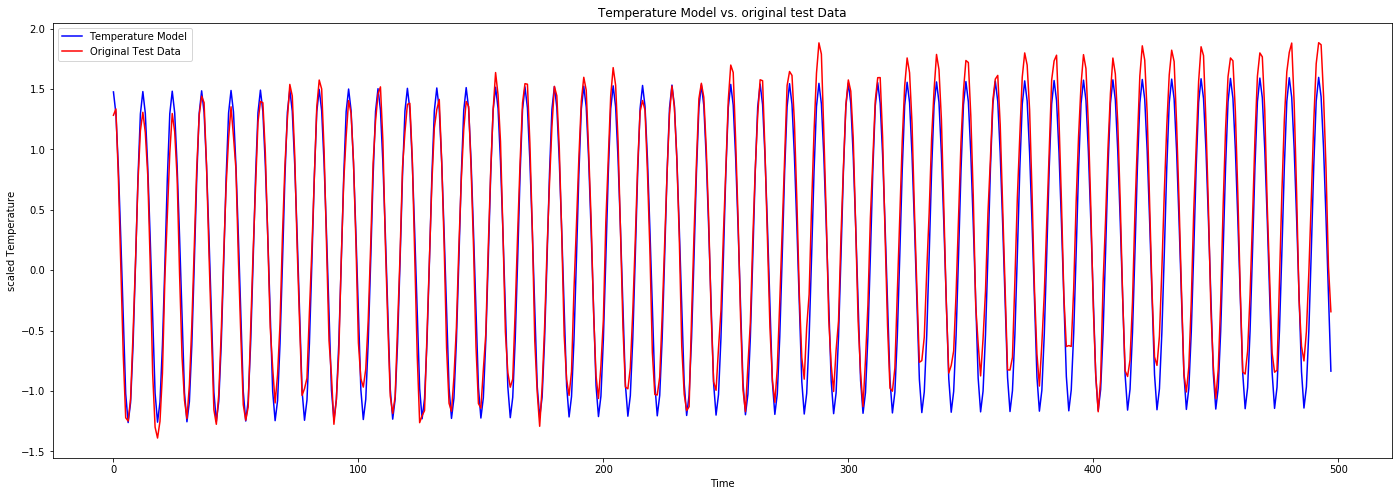

In [55]:
fig = plt.figure(figsize=(24,8))

plt.plot(modelTemp.predict(XT_test), color = 'blue', label = 'Temperature Model')
plt.plot(yt_test, color = 'r', label='Original Test Data')
plt.xlabel('Time')
plt.ylabel('scaled Temperature')
plt.legend()
plt.title('Temperature Model vs. original test Data');